In [77]:
# Dependencies

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
import numpy as np
import tensorflow as tf
import nltk
from collections import Counter
import string
import itertools
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalMaxPool1D, BatchNormalization, Dense, RNN, GRU, LSTM, TimeDistributed, Bidirectional, Activation, Embedding, Input, Conv1D, Dropout
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from transformers import AutoTokenizer, pipeline
from transformers import TFAutoModelForSequenceClassification, TFTrainingArguments, TFTrainer
from scipy.special import softmax
from datasets import DatasetDict, Dataset
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import to_categorical
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
import re
import fasttext

plt.style.use('ggplot')

# Define mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Data read and formatting
df = pd.read_csv('yelp.csv')
df = df.drop(['business_id', 'date', 'review_id', 'type', 'user_id', 'useful', 'funny', 'cool'], axis = 1)
df['Label'] = np.where(df['stars'] >= 3, 1, 0)
df['Id'] = range(1,len(df)+1)
df = df.drop('stars', axis = 1)
df.columns = ['Text', 'Label', 'Id']
df.head()

,Text,Label,Id
0,My wife took me here on my birthday for breakf...,1,1
1,I have no idea why some people give bad review...,1,2
2,love the gyro plate. Rice is so good and I als...,1,3
3,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,4
4,General Manager Scott Petello is a good egg!!!...,1,5


In [15]:
# Remove punctuation
translator = str.maketrans('', '', string.punctuation)
reviews = [s.translate(translator) for s in list(df['Text'])]
reviews = [review.replace('\n', ' ') for review in reviews]

# Tokenization, Lemmatization, Stemming, Stopwords. Label numerical encoding
reviews_tokenized = []
reviews_tokenized_joined = []
for review in reviews:
  splitted_review = nltk.word_tokenize(review)
  splitted_review = [word for word in splitted_review if word not in stop_words]
  splitted_review = [WordNetLemmatizer().lemmatize(w) for w in splitted_review]
  splitted_review = [PorterStemmer().stem(w).strip() for w in splitted_review]
  reviews_tokenized.append(splitted_review)
  joined_review = ' '.join(splitted_review)
  reviews_tokenized_joined.append(joined_review)
  
# Remove empty reviews and the corresponding labels
empty_idx = []
for i, review in enumerate(reviews_tokenized):
  if len(review) == 0:
    empty_idx.append(i)

print(f'Empty indices: {empty_idx}')
labels = list(df['Label'])

for i in empty_idx:
  reviews_tokenized.pop(i)
  reviews_tokenized_joined.pop(i)
  reviews.pop(i)
  labels.pop(i)
  
reviews_unrolled = list(itertools.chain(*reviews_tokenized))

Empty indices: []


### Part 1. Multinomial Naive Bayes with Count Vectorizer

In [24]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews_tokenized_joined, labels, test_size = 0.2, random_state = 1)

MultinomialNB_CountVectorizer_start_time = time.time()

# Count vectorizer feature transformation
count_vector = CountVectorizer(stop_words = 'english', binary = False)

training_data = count_vector.fit_transform(X_train)
test_data = count_vector.transform(X_test)

# Multinomial Naive Bayes model predictions
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB_CountVectorizer_predictions = naive_bayes.predict(test_data)

MultinomialNB_CountVectorizer_end_time = time.time()
MultinomialNB_CountVectorizer_execution_time = MultinomialNB_CountVectorizer_end_time - MultinomialNB_CountVectorizer_start_time

# Model evaluation
print('MultinomialNB CountVectorizer Training time: {} seconds'. format(round(MultinomialNB_CountVectorizer_execution_time, 2)))
print('MultinomialNB CountVectorizer Accuracy score: ', format(accuracy_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer Precision score: ', format(precision_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer Recall score: ', format(recall_score(y_test, MultinomialNB_CountVectorizer_predictions)))
print('MultinomialNB CountVectorizer F1 score: ', format(f1_score(y_test, MultinomialNB_CountVectorizer_predictions)))

# Model evaluation dictionary
MultinomialNB_CountVectorizer_results = {'Name': "MultinomialNB CountVectorizer", 
                                         "Training Time": round(MultinomialNB_CountVectorizer_execution_time, 2),
                                         "Accuracy score": accuracy_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "Precision score": precision_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "Recall score": recall_score(y_test, MultinomialNB_CountVectorizer_predictions),
                                         "F1 score": f1_score(y_test, MultinomialNB_CountVectorizer_predictions)}

MultinomialNB CountVectorizer Training time: 0.35 seconds
MultinomialNB CountVectorizer Accuracy score:  0.872
MultinomialNB CountVectorizer Precision score:  0.8908587257617728
MultinomialNB CountVectorizer Recall score:  0.9646070785842832
MultinomialNB CountVectorizer F1 score:  0.9262672811059908


In [25]:
# Write the results into a pickle file
filename = 'results_dict_list_yelp.pickle'

results_dict_list = [MultinomialNB_CountVectorizer_results]

with open(filename, 'wb') as f:
    pickle.dump(results_dict_list, f)  

### Part 2. Multinomial Naive Bayes with TF-IDF

In [26]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews_tokenized_joined, labels, test_size = 0.2, random_state = 1)

MultinomialNB_tfidf_start_time = time.time()

# TF-IDF feature transformation
tfidf = TfidfVectorizer(stop_words = 'english', binary = False)

training_data = tfidf.fit_transform(X_train)
test_data = tfidf.transform(X_test)

# Multinomial Naive Bayes model predictions
naive_bayes = MultinomialNB()
naive_bayes.fit(training_data, y_train)

MultinomialNB_tfidf_predictions = naive_bayes.predict(test_data)

MultinomialNB_tfidf_end_time = time.time()
MultinomialNB_tfidf_execution_time = MultinomialNB_tfidf_end_time - MultinomialNB_tfidf_start_time

# Model evaluation
print('MultinomialNB tfidf Training time: {} seconds'. format(round(MultinomialNB_tfidf_execution_time, 2)))
print('MultinomialNB tfidf Accuracy score: ', format(accuracy_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf Precision score: ', format(precision_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf Recall score: ', format(recall_score(y_test, MultinomialNB_tfidf_predictions)))
print('MultinomialNB tfidf F1 score: ', format(f1_score(y_test, MultinomialNB_tfidf_predictions)))

# Model evaluation dictionary
MultinomialNB_tfidf_results = {'Name': "MultinomialNB tfidf", 
                                         "Training Time": round(MultinomialNB_tfidf_execution_time, 2),
                                         "Accuracy score": accuracy_score(y_test, MultinomialNB_tfidf_predictions),
                                         "Precision score": precision_score(y_test, MultinomialNB_tfidf_predictions),
                                         "Recall score": recall_score(y_test, MultinomialNB_tfidf_predictions),
                                         "F1 score": f1_score(y_test, MultinomialNB_tfidf_predictions)}

MultinomialNB tfidf Training time: 0.37 seconds
MultinomialNB tfidf Accuracy score:  0.834
MultinomialNB tfidf Precision score:  0.8339169584792396
MultinomialNB tfidf Recall score:  1.0
MultinomialNB tfidf F1 score:  0.9094380796508457


In [27]:
# Update the results pickle file
def update_the_results_file(model_name, filename=filename):
  with open(filename, 'rb') as f:
    results_dict_list = pickle.load(f)
    
  results_dict_list.append(model_name)

  with open(filename, 'wb') as f:
      pickle.dump(results_dict_list, f)
      
update_the_results_file(model_name = MultinomialNB_tfidf_results)

### Part 3. Vaders sentiment classifier

#### Extra preprocessing step

In [28]:
# Create dataframe for convenience
df = pd.DataFrame({'Text': reviews, 'Label': labels})
df = df.reset_index()
df['Id'] = df['index'] + 1
df.drop('index', axis = 1, inplace = True)
df = df[['Id', 'Text', 'Label']]
df.head()

,Id,Text,Label
0,1,My wife took me here on my birthday for breakf...,1
1,2,I have no idea why some people give bad review...,1
2,3,love the gyro plate Rice is so good and I also...,1
3,4,Rosie Dakota and I LOVE Chaparral Dog Park Its...,1
4,5,General Manager Scott Petello is a good egg No...,1


In [29]:
vader_start_time = time.time()

# Define Vader Sentiment analyzer model
sia = SentimentIntensityAnalyzer()

# Get the results
res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
  text = row['Text']
  myid = row['Id']
  res[myid] = sia.polarity_scores(text)
  
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns = {'index': 'Id'})
vaders = vaders.merge(df, how = 'left')
vaders['Predicted_Label'] = np.where(vaders['compound'] >= 0, 1, 0)

vader_end_time = time.time()
vader_execution_time = vader_end_time - vader_start_time

vaders.head()

  0%|          | 0/10000 [00:00<?, ?it/s]

,Id,neg,neu,pos,compound,Text,Label,Predicted_Label
0,1,0.015,0.688,0.297,0.9950,My wife took me here on my birthday for breakf...,1,1
1,2,0.048,0.736,0.215,0.9945,I have no idea why some people give bad review...,1,1
2,3,0.000,0.602,0.398,0.8377,love the gyro plate Rice is so good and I also...,1,1
3,4,0.000,0.805,0.195,0.9436,Rosie Dakota and I LOVE Chaparral Dog Park Its...,1,1
4,5,0.031,0.648,0.321,0.9848,General Manager Scott Petello is a good egg No...,1,1


In [30]:
# Model evaluation
print('Vader Training time: {} seconds'. format(round(vader_execution_time, 2)))
print('Vader Accuracy score: ', format(accuracy_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader Precision score: ', format(precision_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader Recall score: ', format(recall_score(vaders['Label'], vaders['Predicted_Label'])))
print('Vader F1 score: ', format(f1_score(vaders['Label'], vaders['Predicted_Label'])))

# Model evaluation dictionary
vader_results = {'Name': "Vaders Analyser", 
                                         "Training Time": round(vader_execution_time, 2),
                                         "Accuracy score": accuracy_score(vaders['Label'], vaders['Predicted_Label']),
                                         "Precision score": precision_score(vaders['Label'], vaders['Predicted_Label']),
                                         "Recall score": recall_score(vaders['Label'], vaders['Predicted_Label']),
                                         "F1 score": f1_score(vaders['Label'], vaders['Predicted_Label'])}

Vader Training time: 8.74 seconds
Vader Accuracy score:  0.8689
Vader Precision score:  0.8883597297596633
Vader Recall score:  0.9635992311388756
Vader F1 score:  0.9244511035555812


In [31]:
update_the_results_file(model_name = vader_results)

### Part 4. RNN manual implementation

In [34]:
# Create vocabulary, word2index reference and convert the reviews into numerical form
vocab_size = 10000

word_counter = Counter(reviews_unrolled)
word_counter = dict(word_counter.most_common(vocab_size))
word2index = {k:i for i,k in enumerate(word_counter.keys(), start = 3)}

# Convert reveies to integers
reviews_int = []
for review in reviews_tokenized:
  cur_review = [1]
  for word in review:
    if word in word2index.keys():
      cur_review.append(word2index[word])
    else:
      cur_review.append(2)
  reviews_int.append(cur_review)
  
# Pad sequences
padded_reviews = pad_sequences(reviews_int, maxlen = 500, padding = 'pre', truncating = 'pre')

# Train test split on padded sequences
X_train, X_test, y_train, y_test = train_test_split(padded_reviews, labels, test_size = 0.2, random_state = 1)

X_train = np.array(X_train).reshape(8000, 500)
X_test = np.array(X_test).reshape(2000, 500)

y_train = np.array(y_train).reshape(8000, 1)
y_test = np.array(y_test).reshape(2000, 1)

In [37]:
# Define the model
dropout_rate = 0.5

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_RNN_manual_model_amazon.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

inputs = Input(shape = (X_train.shape[1:]))
mask = tf.keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
x = Embedding(input_dim = vocab_size, output_dim = 128, input_length = 200)(inputs)
x = Conv1D(filters = 200, kernel_size = 13, strides = 1, padding = 'same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(128, return_sequences = True)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = GRU(128, return_sequences = False)(x)
x = BatchNormalization()(x)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1, activation = 'sigmoid')(x)

model = Model(inputs = inputs, outputs = outputs)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 500, 128)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 200)          333000    
                                                                 
 batch_normalization_3 (Batc  (None, 500, 200)         800       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 500, 200)          0         
                                                                 
 gru_2 (GRU)                 (None, 500, 128)          126720    
                                                           

In [38]:
# Train the model
Manual_RNN_start_time = time.time()

history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_test, y_test), callbacks = [checkpoint, early_stop])

Manual_RNN_end_time = time.time()
Manual_RNN_execution_time = Manual_RNN_end_time - Manual_RNN_start_time

Epoch 1/10
63/63 [==============================] - 33s 88ms/step - loss: 0.5437 - accuracy: 0.7969 - val_loss: 0.6207 - val_accuracy: 0.8335
Epoch 2/10
63/63 [==============================] - 5s 78ms/step - loss: 0.4992 - accuracy: 0.8176 - val_loss: 0.5380 - val_accuracy: 0.8335
Epoch 3/10
63/63 [==============================] - 5s 76ms/step - loss: 0.4708 - accuracy: 0.8235 - val_loss: 0.5384 - val_accuracy: 0.8340
Epoch 4/10
63/63 [==============================] - 5s 77ms/step - loss: 0.2984 - accuracy: 0.8776 - val_loss: 0.3390 - val_accuracy: 0.8560
Epoch 5/10
63/63 [==============================] - 5s 77ms/step - loss: 0.1657 - accuracy: 0.9364 - val_loss: 0.3077 - val_accuracy: 0.8695
Epoch 6/10
63/63 [==============================] - 5s 74ms/step - loss: 0.0993 - accuracy: 0.9641 - val_loss: 0.3990 - val_accuracy: 0.8345
Epoch 7/10
63/63 [==============================] - 5s 75ms/step - loss: 0.0588 - accuracy: 0.9783 - val_loss: 1.0556 - val_accuracy: 0.7105
Epoch 8/10
6

In [39]:
# Model predictions
Manual_RNN_predictions = model.predict(X_test)

Manual_RNN_predictions_results = []
for i in Manual_RNN_predictions:
  if i[0] >= 0.5:
    Manual_RNN_predictions_results.append(1)
  else:
    Manual_RNN_predictions_results.append(0)

# Model evaluation
print('Manual RNN Training time: {} seconds'. format(round(Manual_RNN_execution_time, 2)))
print('Manual RNN Accuracy score: ', format(accuracy_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN Precision score: ', format(precision_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN Recall score: ', format(recall_score(y_test, Manual_RNN_predictions_results)))
print('Manual RNN F1 score: ', format(f1_score(y_test, Manual_RNN_predictions_results)))

# Model evaluation dictionary
Manual_RNN_results = {'Name': "Manual RNN", 
                 "Training Time": round(Manual_RNN_execution_time, 2),
                 "Accuracy score": accuracy_score(y_test, Manual_RNN_predictions_results),
                 "Precision score": precision_score(y_test, Manual_RNN_predictions_results),
                 "Recall score": recall_score(y_test, Manual_RNN_predictions_results),
                 "F1 score": f1_score(y_test, Manual_RNN_predictions_results)}

63/63 [==============================] - 2s 18ms/step
Manual RNN Training time: 67.21 seconds
Manual RNN Accuracy score:  0.8695
Manual RNN Precision score:  0.9149940968122786
Manual RNN Recall score:  0.9298140371925615
Manual RNN F1 score:  0.9223445403153824


In [40]:
update_the_results_file(Manual_RNN_results)

### Part 5. Universal Sentence encoder transfer learning

In [44]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

X_train = np.array(X_train)
X_test = np.array(X_test)

y_train = np.array(y_train).reshape(8000, 1)
y_test = np.array(y_test).reshape(2000, 1)

In [46]:
# Download the Universal Sentence encoder layer for transfer learning
sentence_encoder_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                         input_shape = [],
                                         dtype=tf.string,
                                         trainable = False)

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='best_sentence_encoder_model_yelp.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

# Define the model
model = Sequential([
  sentence_encoder_layer,
  Dense(1024, activation = 'relu'),
  Dense(1024, activation = 'relu'),
  Dense(1, activation = 'sigmoid')
])

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 258,373,761
Trainable params: 1,575,937
Non-trainable params: 256,797,824
_________________________________________________________________


In [47]:
# Train the model

Sentence_encoder_start_time = time.time()

history = model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_data = (X_test, y_test), callbacks = [checkpoint, early_stop])

Sentence_encoder_end_time = time.time()
Sentence_encoder_execution_time = Sentence_encoder_end_time - Sentence_encoder_start_time

Epoch 1/10
63/63 [==============================] - 11s 133ms/step - loss: 0.3120 - accuracy: 0.8634 - val_loss: 0.2276 - val_accuracy: 0.8985
Epoch 2/10
63/63 [==============================] - 5s 85ms/step - loss: 0.2091 - accuracy: 0.9112 - val_loss: 0.2365 - val_accuracy: 0.9005
Epoch 3/10
63/63 [==============================] - 8s 122ms/step - loss: 0.1829 - accuracy: 0.9241 - val_loss: 0.2246 - val_accuracy: 0.9080
Epoch 4/10
63/63 [==============================] - 5s 86ms/step - loss: 0.1390 - accuracy: 0.9459 - val_loss: 0.2420 - val_accuracy: 0.8965
Epoch 5/10
63/63 [==============================] - 5s 78ms/step - loss: 0.1052 - accuracy: 0.9620 - val_loss: 0.2703 - val_accuracy: 0.8975
Epoch 6/10
63/63 [==============================] - 5s 83ms/step - loss: 0.0628 - accuracy: 0.9805 - val_loss: 0.2922 - val_accuracy: 0.9015
Epoch 6: early stopping


In [48]:
# Model predictions
Sentence_encoder_predictions = model.predict(X_test)

Sentence_encoder_predictions_results = []
for i in Sentence_encoder_predictions:
  if i[0] >= 0.5:
    Sentence_encoder_predictions_results.append(1)
  else:
    Sentence_encoder_predictions_results.append(0)
    
# Model evaluation
print('Sentence encoder Training time: {} seconds'. format(round(Sentence_encoder_execution_time, 2)))
print('Sentence encoder Accuracy score: ', format(accuracy_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder Precision score: ', format(precision_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder Recall score: ', format(recall_score(y_test, Sentence_encoder_predictions_results)))
print('Sentence encoder F1 score: ', format(f1_score(y_test, Sentence_encoder_predictions_results)))

# Model evaluation dictionary
Sentence_encoder_results = {'Name': "Sentence encoder", 
                 "Training Time": round(Sentence_encoder_execution_time, 2),
                 "Accuracy score": accuracy_score(y_test, Sentence_encoder_predictions_results),
                 "Precision score": precision_score(y_test, Sentence_encoder_predictions_results),
                 "Recall score": recall_score(y_test, Sentence_encoder_predictions_results),
                 "F1 score": f1_score(y_test, Sentence_encoder_predictions_results)}

63/63 [==============================] - 1s 17ms/step
Sentence encoder Training time: 39.78 seconds
Sentence encoder Accuracy score:  0.908
Sentence encoder Precision score:  0.9318578916715201
Sentence encoder Recall score:  0.9598080383923215
Sentence encoder F1 score:  0.9456264775413711


In [49]:
update_the_results_file(Sentence_encoder_results)

### Part 6. Roberta Huggingface model

In [50]:
# Download the pretrained model
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [51]:
# Auxillary polarity scores function
def polarity_scores_roberta(example):
  encoded_text = tokenizer(example, return_tensors = 'tf')
  output = model(**encoded_text)
  scores = output[0][0].numpy()
  scores = softmax(scores)
  scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
  }
  return scores_dict

In [52]:
# Predict results with each of the rows in the dataframe

Roberta_start_time = time.time()

res = {}
for i, row in tqdm(df.iterrows(), total = len(df)):
    text = row['Text']
    myid = row['Id']
    vader_result = sia.polarity_scores(text)

    vader_result_rename = {}
    for key, value in vader_result.items():
      vader_result_rename[f'vader_{key}'] = value

    roberta_result = polarity_scores_roberta(text)
    both_results = {**vader_result_rename, **roberta_result}
    res[myid] = both_results
    
Roberta_end_time = time.time()
Roberta_execution_time = Roberta_end_time - Roberta_start_time

  0%|          | 0/10000 [00:00<?, ?it/s]

In [54]:
# Save roberta model results
roberta_results = []
for i in range(1, len(df) + 1):
  roberta_results.append(int(res[i]['roberta_pos'] > res[i]['roberta_neg']))
  
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns = {'index': 'Id'})
results_df = results_df.merge(vaders, how = 'left')
results_df.drop(['neg', 'neu', 'pos', 'compound'], axis = 1, inplace = True)

results_df['Roberta_Predictions'] = results_df['roberta_pos'] > results_df['roberta_neg']
results_df['Roberta_Predictions'] = results_df['Roberta_Predictions'].astype(int)
results_df.head(3)

,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Text,Label,Predicted_Label,Roberta_Predictions
0,1,0.015,0.688,0.297,0.9950,0.002489,0.008888,0.988281,My wife took me here on my birthday for breakf...,1,1,1
1,2,0.048,0.736,0.215,0.9945,0.035522,0.160767,0.803711,I have no idea why some people give bad review...,1,1,1
2,3,0.000,0.602,0.398,0.8377,0.001597,0.008469,0.990234,love the gyro plate Rice is so good and I also...,1,1,1


In [55]:
# Model evaluation
print('Roberta Training time: {} seconds'. format(round(Roberta_execution_time, 2)))
print('Roberta Accuracy score: ', format(accuracy_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta Precision score: ', format(precision_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta Recall score: ', format(recall_score(results_df['Label'], results_df['Roberta_Predictions'])))
print('Roberta F1 score: ', format(f1_score(results_df['Label'], results_df['Roberta_Predictions'])))

# Model evaluation dictionary
Roberta_results = {'Name': "Roberta", 
                 "Training Time": round(Roberta_execution_time, 2),
                 "Accuracy score": accuracy_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "Precision score": precision_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "Recall score": recall_score(results_df['Label'], results_df['Roberta_Predictions']),
                 "F1 score": f1_score(results_df['Label'], results_df['Roberta_Predictions'])}

Roberta Training time: 1425.77 seconds
Roberta Accuracy score:  0.9105
Roberta Precision score:  0.9573944095554735
Roberta Recall score:  0.9340461316674675
Roberta F1 score:  0.9455761629674674


In [56]:
update_the_results_file(Roberta_results)

### Part 7. Distilbert Fine Tuned huggingface (native tensorflow)

In [58]:
# Define huggingface dataset object and train test split
ds = Dataset.from_dict({'reviews': reviews, 'labels': labels})
dataset = ds.train_test_split()

# Model name and hyperparameters
checkpoint = 'distilbert-base-uncased'
batch_size = 16
max_length = 300

# Tokenizer object
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Tokenization auxillary function
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['reviews'], padding='max_length', truncation=True, max_length = max_length)
  
# Tokenized dataset
tokenized_dataset = dataset.map(tokenize_function, batched=True)
train_dataset = tokenized_dataset['train']
test_dataset = tokenized_dataset['test']
train_dataset = train_dataset.remove_columns(['reviews']).with_format('tensorflow')
test_dataset = test_dataset.remove_columns(['reviews']).with_format('tensorflow')

# Training features and tensorflow dataset
train_features = {x: train_dataset[x] for x in tokenizer.model_input_names}
train_set = tf.data.Dataset.from_tensor_slices((train_features, train_dataset['labels'])).shuffle(1000).batch(batch_size)

test_features = {x: test_dataset[x] for x in tokenizer.model_input_names}
test_set = tf.data.Dataset.from_tensor_slices((test_features, test_dataset['labels'])).shuffle(1000).batch(batch_size)

test_set_for_preds = tf.data.Dataset.from_tensor_slices((test_features, test_dataset['labels'])).batch(batch_size)

Map:   0%|          | 0/7500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [59]:
# Download pretrained model from checkpoint (Only the head layer is trainable)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
model.layers[0].trainable = True

# Model checkpoint callback
checkpoint = ModelCheckpoint(filepath='HF_BERT_finetuned_tf_model_yelp.h5', 
                             monitor='val_loss', 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto')

# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           verbose=1, 
                           restore_best_weights=True)

# Model compilation
model.compile(
  optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-6),
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
  metrics = ['accuracy']
)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_65', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [60]:
HF_TF_finetuned_start_time = time.time()

# Model finetuning
history = model.fit(train_set,
                   validation_data = test_set,
                   epochs = 200,
                   batch_size = batch_size,
                   callbacks = [checkpoint, early_stop])

HF_TF_finetuned_end_time = time.time()
HF_TF_finetuned_execution_time = HF_TF_finetuned_end_time - HF_TF_finetuned_start_time

Epoch 1/200
469/469 [==============================] - 109s 216ms/step - loss: 0.3179 - accuracy: 0.8763 - val_loss: 0.1979 - val_accuracy: 0.9208
Epoch 2/200
469/469 [==============================] - 99s 211ms/step - loss: 0.1815 - accuracy: 0.9279 - val_loss: 0.2112 - val_accuracy: 0.9152
Epoch 3/200
469/469 [==============================] - 102s 217ms/step - loss: 0.1350 - accuracy: 0.9471 - val_loss: 0.2117 - val_accuracy: 0.9236
Epoch 4/200
469/469 [==============================] - 101s 216ms/step - loss: 0.0952 - accuracy: 0.9668 - val_loss: 0.2303 - val_accuracy: 0.9176
Epoch 4: early stopping


In [61]:
predictions = model.predict(test_set_for_preds)
predictions = tf.math.argmax(tf.nn.softmax(predictions[0], axis = -1), axis = -1)
predictions = tf.cast(predictions, dtype = tf.int32)

# Model evaluation
print('HF_TF_finetuned Training time: {} seconds'. format(round(HF_TF_finetuned_execution_time, 2)))
print('HF_TF_finetuned Accuracy score: ', format(accuracy_score(predictions, test_dataset['labels'])))
print('HF_TF_finetuned Precision score: ', format(precision_score(predictions, test_dataset['labels'])))
print('HF_TF_finetuned Recall score: ', format(recall_score(predictions, test_dataset['labels'])))
print('HF_TF_finetuned F1 score: ', format(f1_score(predictions, test_dataset['labels'])))

# Model evaluation dictionary
HF_TF_finetuned_results = {'Name': "HF_TF_finetuned", 
                 "Training Time": round(HF_TF_finetuned_execution_time, 2),
                 "Accuracy score": accuracy_score(predictions, test_dataset['labels']),
                 "Precision score": precision_score(predictions, test_dataset['labels']),
                 "Recall score": recall_score(predictions, test_dataset['labels']),
                 "F1 score": f1_score(predictions, test_dataset['labels'])}

157/157 [==============================] - 11s 60ms/step
HF_TF_finetuned Training time: 410.83 seconds
HF_TF_finetuned Accuracy score:  0.9208
HF_TF_finetuned Precision score:  0.9586935638808838
HF_TF_finetuned Recall score:  0.9468690702087287
HF_TF_finetuned F1 score:  0.9527446300715989


In [62]:
update_the_results_file(HF_TF_finetuned_results)

### Part 8. Distilbert Fine Tuned huggingface (trainer object)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(reviews, labels, test_size = 0.2, random_state = 1)

In [64]:
max_length = 300

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train, truncation = True, padding = True, max_length = max_length)
test_encodings = tokenizer(X_test, truncation = True, padding = True, max_length = max_length)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

In [65]:
training_args = TFTrainingArguments(
  output_dir = './results',
  num_train_epochs = 10,
  per_device_eval_batch_size = 4,
  per_device_train_batch_size = 4,
  warmup_steps = 500,
  weight_decay = 0.01,
  logging_dir = './logs',
  logging_steps = 10,
  eval_steps = 50,
)

In [66]:
HF_trainer_finetuned_start_time = time.time()

with training_args.strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
  
trainer = TFTrainer(
  model = model,
  args = training_args,
  train_dataset = train_dataset,
  eval_dataset = test_dataset
)

trainer.train()

HF_trainer_finetuned_end_time = time.time()
HF_trainer_finetuned_execution_time = HF_trainer_finetuned_end_time - HF_trainer_finetuned_start_time

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_85', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [67]:
predictions = trainer.predict(test_dataset)
predictions = tf.math.argmax(tf.nn.softmax(predictions[0], axis = -1), axis = -1)

# Model evaluation
print('HF_trainer_finetuned Training time: {} seconds'. format(round(HF_trainer_finetuned_execution_time, 2)))
print('HF_trainer_finetuned Accuracy score: ', format(accuracy_score(predictions, y_test)))
print('HF_trainer_finetuned Precision score: ', format(precision_score(predictions, y_test)))
print('HF_trainer_finetuned Recall score: ', format(recall_score(predictions, y_test)))
print('HF_trainer_finetuned F1 score: ', format(f1_score(predictions, y_test)))

# Model evaluation dictionary
HF_trainer_finetuned_results = {'Name': "HF_trainer_finetuned", 
                 "Training Time": round(HF_trainer_finetuned_execution_time, 2),
                 "Accuracy score": accuracy_score(predictions, y_test),
                 "Precision score": precision_score(predictions, y_test),
                 "Recall score": recall_score(predictions, y_test),
                 "F1 score": f1_score(predictions, y_test)}

HF_trainer_finetuned Training time: 1694.6 seconds
HF_trainer_finetuned Accuracy score:  0.9015
HF_trainer_finetuned Precision score:  0.9586082783443312
HF_trainer_finetuned Recall score:  0.9258400926998841
HF_trainer_finetuned F1 score:  0.941939286766873


In [68]:
update_the_results_file(HF_trainer_finetuned_results)

### Part 9. High level pipeline huggingface

In [70]:
classifier = pipeline('sentiment-analysis', device = 0)

HF_pipeline_start_time = time.time()
results = []
for i in range(len(reviews)):
  results.append(classifier(reviews[i]))
  if i % 1000 == 0:
    print(i)
HF_pipeline_end_time = time.time()
HF_pipeline_execution_time = HF_pipeline_end_time - HF_pipeline_start_time
HF_pipeline_execution_time

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

0


Token indices sequence length is longer than the specified maximum sequence length for this model (779 > 512). Running this sequence through the model will result in indexing errors


1000
2000
3000
4000
5000
6000
7000
8000
9000


774.0700061321259

In [71]:
preds = []
for result in results:
  if result[0]['label'] == "POSITIVE":
    preds.append(1)
  else:
    preds.append(0)
    
# Model evaluation
print('HF_pipeline Training time: {} seconds'. format(round(HF_pipeline_execution_time, 2)))
print('HF_pipeline Accuracy score: ', format(accuracy_score(preds, labels)))
print('HF_pipeline Precision score: ', format(precision_score(preds, labels)))
print('HF_pipeline Recall score: ', format(recall_score(preds, labels)))
print('HF_pipeline F1 score: ', format(f1_score(preds, labels)))

# Model evaluation dictionary
HF_pipeline_results = {'Name': "HF_pipeline", 
                 "Training Time": round(HF_pipeline_execution_time, 2),
                 "Accuracy score": accuracy_score(preds, labels),
                 "Precision score": precision_score(preds, labels),
                 "Recall score": recall_score(preds, labels),
                 "F1 score": f1_score(preds, labels)}

HF_pipeline Training time: 774.07 seconds
HF_pipeline Accuracy score:  0.783
HF_pipeline Precision score:  0.7518020182604517
HF_pipeline Recall score:  0.9836529393272556
HF_pipeline F1 score:  0.8522402287893233


In [72]:
update_the_results_file(HF_pipeline_results)

### Part 10. Fasttext classifier

In [91]:
reviews = [review.replace('\n', ' ') for review in reviews]

df = pd.DataFrame({'label' : labels, 'review': reviews})
df['label_upd'] = '__label__' + df['label'].astype(str)
df['label_review'] = df['label_upd'] + ' ' + df['review']

def preprocess(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(' +', ' ', text)
    return text.strip().lower()
  
df['label_review'] = df['label_review'].map(preprocess)

train, test = train_test_split(df, test_size = 0.2, random_state = 1)

train.to_csv('imdb.train', columns = ['label_review'], index = False, header = False)
test.to_csv('imdb.test', columns = ['label_review'], index = False, header = False)

Fasttext_start_time = time.time()

model = fasttext.train_supervised(input = 'imdb.train')

Fasttext_end_time = time.time()
Fasttext_execution_time = Fasttext_end_time - Fasttext_start_time

In [92]:
predictions = model.predict(list(test['review'].values))

preds = []
for pred in predictions[0]:
  if pred == ['__label__1']:
    preds.append(1)
  else:
    preds.append(0)
    
# Model evaluation
print('Fasttext Training time: {} seconds'. format(round(Fasttext_execution_time, 2)))
print('Fasttext Accuracy score: ', format(accuracy_score(preds, test['label'])))
print('Fasttext Precision score: ', format(precision_score(preds, test['label'])))
print('Fasttext Recall score: ', format(recall_score(preds, test['label'])))
print('Fasttext F1 score: ', format(f1_score(preds, test['label'])))

# Model evaluation dictionary
Fasttext_results = {'Name': "Fasttext", 
                 "Training Time": round(Fasttext_execution_time, 2),
                 "Accuracy score": accuracy_score(preds, test['label']),
                 "Precision score": precision_score(preds, test['label']),
                 "Recall score": recall_score(preds, test['label']),
                 "F1 score": f1_score(preds, test['label'])}

Fasttext Training time: 0.32 seconds
Fasttext Accuracy score:  0.8785
Fasttext Precision score:  0.9676064787042592
Fasttext Recall score:  0.8951165371809101
Fasttext F1 score:  0.9299509945229173


In [93]:
update_the_results_file(Fasttext_results)

### All models summary

In [94]:
# Create a DataFrame with a summary for all models and KPIs

file_name = filename

with open(file_name, 'rb') as f:
    results_dict_list = pickle.load(f)
df = pd.DataFrame(results_dict_list)
df

,Name,Training Time,Accuracy score,Precision score,Recall score,F1 score
0,MultinomialNB CountVectorizer,0.35,0.8720,0.890859,0.964607,0.926267
1,MultinomialNB tfidf,0.37,0.8340,0.833917,1.000000,0.909438
2,Vaders Analyser,8.74,0.8689,0.888360,0.963599,0.924451
3,Manual RNN,67.21,0.8695,0.914994,0.929814,0.922345
4,Sentence encoder,39.78,0.9080,0.931858,0.959808,0.945626
5,Roberta,1425.77,0.9105,0.957394,0.934046,0.945576
6,HF_TF_finetuned,410.83,0.9208,0.958694,0.946869,0.952745
7,HF_trainer_finetuned,1694.60,0.9015,0.958608,0.925840,0.941939
8,HF_pipeline,774.07,0.7830,0.751802,0.983653,0.852240
9,Fasttext,0.32,0.8785,0.967606,0.895117,0.929951


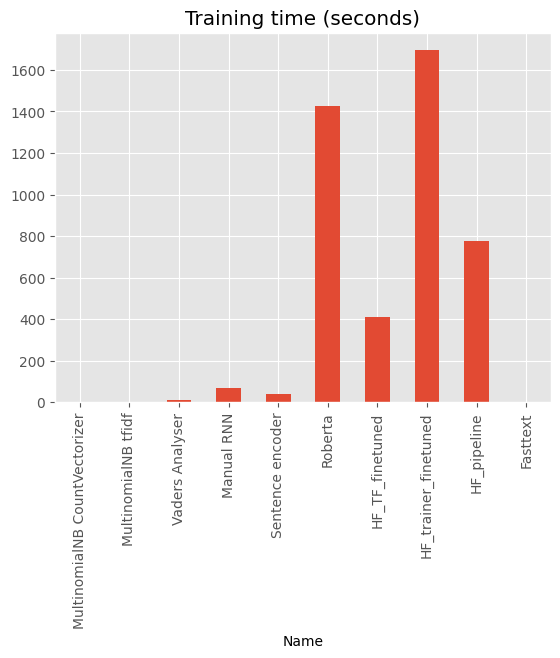

In [95]:
# Training time
df.plot(kind='bar', x='Name', y='Training Time')
plt.title("Training time (seconds)")
plt.legend().remove()